In [1]:
import os
import collections
import pandas as pd
import numpy as np
import functools
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms, datasets, models

from sklearn import preprocessing 
from tqdm.notebook import tqdm
import math

import xml.etree.ElementTree as ET

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torchvision import transforms, datasets, models


import torch
from PIL import Image
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import SequentialSampler

In [2]:
import os
import shutil

def organize_files(source_folder):
    # Define destination folders
    jpg_folder = os.path.join(source_folder, "JPG_Files")
    xml_folder = os.path.join(source_folder, "XML_Files")
    
    # Create destination folders if they don't exist
    os.makedirs(jpg_folder, exist_ok=True)
    os.makedirs(xml_folder, exist_ok=True)
    
    # Iterate over files in the source folder
    for filename in os.listdir(source_folder):
        # Full path to the file
        file_path = os.path.join(source_folder, filename)
        
        # Check if it is a file (not a directory)
        if os.path.isfile(file_path):
            if filename.lower().endswith(".jpg"):
                # Move .jpg file to JPG_Files folder
                shutil.move(file_path, os.path.join(jpg_folder, filename))
            elif filename.lower().endswith(".xml"):
                # Move .xml file to XML_Files folder
                shutil.move(file_path, os.path.join(xml_folder, filename))

# Example usage
source_folder = "./dataset/train/"  # Replace with the path to your folder
organize_files(source_folder)


In [3]:
BASE_PATH = "./dataset/train/"
XML_PATH = os.path.join(BASE_PATH, "XML_Files")
IMG_PATH = os.path.join(BASE_PATH, "JPG_Files")
XML_FILES = [os.path.join(XML_PATH, f) for f in os.listdir(XML_PATH)]


In [1]:
len(XML_FILES), XML_FILES

## **Extract info. from xml files**

In [5]:
class XmlParser(object):

    def __init__(self,xml_file):

        self.xml_file = xml_file
        self._root = ET.parse(self.xml_file).getroot()
        self._objects = self._root.findall("object")
        # path to the image file as describe in the xml file
        self.img_path = os.path.join(IMG_PATH, self._root.find('filename').text)
        # image id 
        self.image_id = self._root.find("filename").text
        # names of the classes contained in the xml file
        self.names = self._get_names()
        # coordinates of the bounding boxes
        self.boxes = self._get_bndbox()

    def parse_xml(self):
        """"Parse the xml file returning the root."""
    
        tree = ET.parse(self.xml_file)
        return tree.getroot()

    def _get_names(self):

        names = []
        for obj in self._objects:
            name = obj.find("name")
            names.append(name.text)

        return np.array(names)

    def _get_bndbox(self):

        boxes = []
        for obj in self._objects:
            coordinates = []
            bndbox = obj.find("bndbox")
            coordinates.append(np.int32(bndbox.find("xmin").text))
            coordinates.append(np.int32(np.float32(bndbox.find("ymin").text)))
            coordinates.append(np.int32(bndbox.find("xmax").text))
            coordinates.append(np.int32(bndbox.find("ymax").text))
            boxes.append(coordinates)

        return np.array(boxes)

## **Make dataframe from extracted information**

In [6]:
def xml_files_to_df(xml_files):
    
    """"Return pandas dataframe from list of XML files."""
    
    names = []
    boxes = []
    image_id = []
    xml_path = []
    img_path = []
    for file in xml_files:
        xml = XmlParser(file) # <__main__.XmlParser object at 0x00000248B9C26750>
        names.extend(xml.names) #extract objects data
        boxes.extend(xml.boxes)
        image_id.extend([xml.image_id] * len(xml.names))
        xml_path.extend([xml.xml_file] * len(xml.names))
        img_path.extend([xml.img_path] * len(xml.names))
    a = {"image_id": image_id, # make dict to store further in dataframe
         "names": names,
         "boxes": boxes,
         "xml_path":xml_path,
         "img_path":img_path}
    
    df = pd.DataFrame.from_dict(a, orient='index')
    df = df.transpose()
    
    
    return df

df = xml_files_to_df(XML_FILES)
df.head()

,image_id,names,boxes,xml_path,img_path
0,0.jpg,LP,"[1309, 1897, 1701, 2092]",./dataset/train/XML_Files\0.xml,./dataset/train/JPG_Files\0.jpg
1,1.jpg,LP,"[697, 1952, 1138, 2152]",./dataset/train/XML_Files\1.xml,./dataset/train/JPG_Files\1.jpg
2,10.jpg,LP,"[563, 571, 1131, 739]",./dataset/train/XML_Files\10.xml,./dataset/train/JPG_Files\10.jpg
3,100.jpg,LP,"[357, 331, 568, 386]",./dataset/train/XML_Files\100.xml,./dataset/train/JPG_Files\100.jpg
4,101.jpg,LP,"[747, 1630, 1034, 1730]",./dataset/train/XML_Files\101.xml,./dataset/train/JPG_Files\101.jpg


In [7]:
df.shape

(504, 5)

---

In [8]:
# check values for per class
df['names'].value_counts()

names
LP    504
Name: count, dtype: int64

In [9]:
# remove .jpg extension from image_id 
df['img_id'] = df['image_id'].apply(lambda x:x.split('.')).map(lambda x:x[0])
df.drop(columns=['image_id'], inplace=True)
df.head()

,names,boxes,xml_path,img_path,img_id
0,LP,"[1309, 1897, 1701, 2092]",./dataset/train/XML_Files\0.xml,./dataset/train/JPG_Files\0.jpg,0
1,LP,"[697, 1952, 1138, 2152]",./dataset/train/XML_Files\1.xml,./dataset/train/JPG_Files\1.jpg,1
2,LP,"[563, 571, 1131, 739]",./dataset/train/XML_Files\10.xml,./dataset/train/JPG_Files\10.jpg,10
3,LP,"[357, 331, 568, 386]",./dataset/train/XML_Files\100.xml,./dataset/train/JPG_Files\100.jpg,100
4,LP,"[747, 1630, 1034, 1730]",./dataset/train/XML_Files\101.xml,./dataset/train/JPG_Files\101.jpg,101


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   names     504 non-null    object
 1   boxes     504 non-null    object
 2   xml_path  504 non-null    object
 3   img_path  504 non-null    object
 4   img_id    504 non-null    object
dtypes: object(5)
memory usage: 19.8+ KB


 we need to add one because 0 is for background in fasterRcnn model so our
  Fully Connected layers have 1+1= 2 outputs , 1 is for number of labels if 2 then it is 2, another 1 is for background which is fix
  
  
  other wise dont use iscrowd and area

In [11]:
# classes need to be in int form so we use LabelEncoder for this task
labels=[]
enc = preprocessing.LabelEncoder()
df['labels'] = enc.fit_transform(df['names'])
for i in range(len(df['labels'])):
    labels.append(df['labels'][i]+1)  
df['labels'] = np.stack(labels) 
df.head()

,names,boxes,xml_path,img_path,img_id,labels
0,LP,"[1309, 1897, 1701, 2092]",./dataset/train/XML_Files\0.xml,./dataset/train/JPG_Files\0.jpg,0,1
1,LP,"[697, 1952, 1138, 2152]",./dataset/train/XML_Files\1.xml,./dataset/train/JPG_Files\1.jpg,1,1
2,LP,"[563, 571, 1131, 739]",./dataset/train/XML_Files\10.xml,./dataset/train/JPG_Files\10.jpg,10,1
3,LP,"[357, 331, 568, 386]",./dataset/train/XML_Files\100.xml,./dataset/train/JPG_Files\100.jpg,100,1
4,LP,"[747, 1630, 1034, 1730]",./dataset/train/XML_Files\101.xml,./dataset/train/JPG_Files\101.jpg,101,1


In [12]:
classes = df[['names','labels']].value_counts()
classes

names  labels
LP     1         504
Name: count, dtype: int64

In [13]:
df.head()

,names,boxes,xml_path,img_path,img_id,labels
0,LP,"[1309, 1897, 1701, 2092]",./dataset/train/XML_Files\0.xml,./dataset/train/JPG_Files\0.jpg,0,1
1,LP,"[697, 1952, 1138, 2152]",./dataset/train/XML_Files\1.xml,./dataset/train/JPG_Files\1.jpg,1,1
2,LP,"[563, 571, 1131, 739]",./dataset/train/XML_Files\10.xml,./dataset/train/JPG_Files\10.jpg,10,1
3,LP,"[357, 331, 568, 386]",./dataset/train/XML_Files\100.xml,./dataset/train/JPG_Files\100.jpg,100,1
4,LP,"[747, 1630, 1034, 1730]",./dataset/train/XML_Files\101.xml,./dataset/train/JPG_Files\101.jpg,101,1


In [14]:
# bounding box coordinates point need to be in separate columns

df['xmin'] = -1
df['ymin'] = -1
df['xmax'] = -1
df['ymax'] = -1

boxes=[]
for i in range(len(df['boxes'])):
    boxes.append(df['boxes'][i])

df[['xmin','ymin','xmax','ymax']]=np.stack(boxes)

df.drop(columns=['boxes'], inplace=True)
df['xmin'] = df['xmin'].astype(np.float32)
df['ymin'] = df['ymin'].astype(np.float32)
df['xmax'] = df['xmax'].astype(np.float32)
df['ymax'] = df['ymax'].astype(np.float32)

In [15]:
# drop names column since we dont need it anymore
df.drop(columns=['names'], inplace=True)
df.head()

,xml_path,img_path,img_id,labels,xmin,ymin,xmax,ymax
0,./dataset/train/XML_Files\0.xml,./dataset/train/JPG_Files\0.jpg,0,1,1309.0,1897.0,1701.0,2092.0
1,./dataset/train/XML_Files\1.xml,./dataset/train/JPG_Files\1.jpg,1,1,697.0,1952.0,1138.0,2152.0
2,./dataset/train/XML_Files\10.xml,./dataset/train/JPG_Files\10.jpg,10,1,563.0,571.0,1131.0,739.0
3,./dataset/train/XML_Files\100.xml,./dataset/train/JPG_Files\100.jpg,100,1,357.0,331.0,568.0,386.0
4,./dataset/train/XML_Files\101.xml,./dataset/train/JPG_Files\101.jpg,101,1,747.0,1630.0,1034.0,1730.0


In [16]:
len(df['img_id'].unique()), df.shape # see total images in folder are 17125 but here one imgage have multi object detection

(504, (504, 8))

## **Separate train and validation data**

In [17]:
# import packages 
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split 

# using the train test split function 
train_df, valid_df = train_test_split(df, random_state=104, test_size=0.40, shuffle=True) 
valid_df.shape, train_df.shape


((202, 8), (302, 8))

In [18]:
valid_df.head()

,xml_path,img_path,img_id,labels,xmin,ymin,xmax,ymax
152,./dataset/train/XML_Files\235.xml,./dataset/train/JPG_Files\235.jpg,235,1,78.0,138.0,153.0,162.0
261,./dataset/train/XML_Files\333.xml,./dataset/train/JPG_Files\333.jpg,333,1,1.0,479.0,77.0,567.0
135,./dataset/train/XML_Files\22.xml,./dataset/train/JPG_Files\22.jpg,22,1,506.0,199.0,544.0,330.0
41,./dataset/train/XML_Files\135.xml,./dataset/train/JPG_Files\135.jpg,135,1,792.0,326.0,898.0,401.0
109,./dataset/train/XML_Files\197.xml,./dataset/train/JPG_Files\197.jpg,197,1,210.0,913.0,486.0,1008.0


In [19]:
train_df.head()

,xml_path,img_path,img_id,labels,xmin,ymin,xmax,ymax
275,./dataset/train/XML_Files\346.xml,./dataset/train/JPG_Files\346.jpg,346,1,453.0,841.0,610.0,878.0
297,./dataset/train/XML_Files\366.xml,./dataset/train/JPG_Files\366.jpg,366,1,313.0,606.0,473.0,647.0
427,./dataset/train/XML_Files\483.xml,./dataset/train/JPG_Files\483.jpg,483,1,88.0,576.0,172.0,632.0
16,./dataset/train/XML_Files\112.xml,./dataset/train/JPG_Files\112.jpg,112,1,343.0,552.0,550.0,606.0
175,./dataset/train/XML_Files\256.xml,./dataset/train/JPG_Files\256.jpg,256,1,766.0,424.0,837.0,484.0


In [20]:
df.describe()

,labels,xmin,ymin,xmax,ymax
count,504.0,504.000000,504.000000,504.000000,504.000000
mean,1.0,434.666656,567.216248,637.121033,644.212280
std,0.0,326.241028,336.637878,380.728851,364.934418
min,1.0,1.000000,1.000000,77.000000,156.000000
25%,1.0,231.000000,365.750000,401.500000,427.750000
50%,1.0,330.000000,481.500000,543.000000,554.500000
75%,1.0,561.250000,651.000000,784.750000,729.500000
max,1.0,1631.000000,3470.000000,2380.000000,3675.000000


## **Make dataset by Dataset Module** 

In [21]:
len(df[df.ymax>df.ymin])

504

In [22]:
# Calculate Max_length for normalization can also use min max scalor directly
for paths in df.img_path.unique().tolist():
    image = cv2.imread(paths, cv2.IMREAD_COLOR) # cv2.IMREAD_COLORIt specifies to load a color image. Any transparency of image will be neglected. It is the default flag.
    # print(image,"image\n\n")

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) # change in float # COLOR_BGR2RGB color from blue green red to red green blue
    # print(image,"image\n\n")
    max_value = np.max(image)
    print(max_value) 
#     image /= 255.0 # our image vectors should be in range of 0,1 
#     print(image,"image\n\n")
    break

255.0


MinMAxScalor

In [23]:
# for paths in df.img_path.unique().tolist():
#     image = cv2.imread(paths, cv2.IMREAD_COLOR) # cv2.IMREAD_COLORIt specifies to load a color image. Any transparency of image will be neglected. It is the default flag.
#     # print(image,"image\n\n")

#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) # change in float # COLOR_BGR2RGB color from blue green red to red green blue
#     # print(image,"image\n\n")
#     max_value = np.max(image)
#     print(max_value)
#     # Reshape the image to a 2D array (required by MinMaxScaler)
#     image_reshaped = image.reshape(-1, 1)

#     # Create a MinMaxScaler with the desired range
#     scaler = MinMaxScaler(feature_range=(0, 1))

#     # Fit and transform the image array
#     normalized_image_reshaped = scaler.fit_transform(image_reshaped)

#     # Reshape back to the original image shape
#     normalized_image = normalized_image_reshaped.reshape(image.shape)

#     # Print the normalized image array
#     print("Normalized image array:\n", normalized_image)
#     # image /= 255.0 # our image vectors should be in range of 0,1 
#     # print(image,"image\n\n")
#     break

In [24]:
class VOCDataset(Dataset):
    
    def __init__(self, dataframe, image_dir, transforms):
        super().__init__()
        
        self.image_ids = dataframe['img_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        #print(self.image_ids, self.df, "==================",self.image_dir,"---------------", self.transforms)
    
    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        records = self.df[self.df['img_id'] == image_id]
        
        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) #openCV2 for image colorization
        image /= 255.0
        rows, cols = image.shape[:2]
        
        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values
        #print(boxes)

        
       
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        label = records['labels'].values
        labels = torch.as_tensor(label, dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = torch.from_numpy(boxes)
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd # may be for background 
        
        if self.transforms is not None:
            image = self.transforms(image)
            
        return image, target
        
    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [25]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
   ]
)

In [26]:
VC = VOCDataset(df, IMG_PATH, transform)
VC

In [28]:
# coun=0
# for x,y in VC:
#     coun+=1
#     print(x,y)
#     print("------------------------------")
# #     break
# print(coun)

In [29]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = VOCDataset(train_df, IMG_PATH , transform)
valid_dataset = VOCDataset(valid_df, IMG_PATH, transform)

batch_size = 4

train_data_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)


valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)



In [30]:
len(train_data_loader), len(valid_data_loader)

(76, 51)

In [31]:
for x in train_data_loader:
    print(x)
    break

((tensor([[[0.9804, 0.9843, 0.9882,  ..., 0.6745, 0.6745, 0.6745],
         [0.9804, 0.9843, 0.9882,  ..., 0.6745, 0.6745, 0.6745],
         [0.9843, 0.9843, 0.9922,  ..., 0.6745, 0.6745, 0.6745],
         ...,
         [0.2353, 0.2353, 0.2275,  ..., 0.5098, 0.5255, 0.5216],
         [0.2314, 0.2314, 0.2275,  ..., 0.4902, 0.5137, 0.5373],
         [0.2353, 0.2353, 0.2314,  ..., 0.4706, 0.4941, 0.5490]],

        [[0.9804, 0.9843, 0.9882,  ..., 0.7216, 0.7216, 0.7216],
         [0.9804, 0.9843, 0.9882,  ..., 0.7216, 0.7216, 0.7216],
         [0.9843, 0.9843, 0.9922,  ..., 0.7216, 0.7216, 0.7216],
         ...,
         [0.3020, 0.3020, 0.2980,  ..., 0.5137, 0.5294, 0.5255],
         [0.2980, 0.2980, 0.2941,  ..., 0.4941, 0.5176, 0.5412],
         [0.3020, 0.3020, 0.2980,  ..., 0.4745, 0.4980, 0.5529]],

        [[0.9804, 0.9843, 0.9882,  ..., 0.7686, 0.7686, 0.7686],
         [0.9804, 0.9843, 0.9882,  ..., 0.7686, 0.7686, 0.7686],
         [0.9843, 0.9843, 0.9922,  ..., 0.7686, 0.7686, 

In [32]:
X,y =  next(iter(valid_data_loader))
X,y

((tensor([[[1.0000, 0.6784, 0.6745,  ..., 0.5686, 0.5686, 0.5686],
           [1.0000, 0.6627, 0.6431,  ..., 0.5608, 0.5608, 0.5608],
           [1.0000, 0.5686, 0.5608,  ..., 0.5490, 0.5490, 0.5490],
           ...,
           [1.0000, 0.6784, 0.5961,  ..., 0.7373, 0.7451, 0.7490],
           [1.0000, 0.6824, 0.6000,  ..., 0.7529, 0.7569, 0.7569],
           [1.0000, 0.6863, 0.6039,  ..., 0.7725, 0.7647, 0.7647]],
  
          [[0.9922, 0.6627, 0.6588,  ..., 0.4941, 0.4902, 0.4902],
           [0.9961, 0.6471, 0.6275,  ..., 0.4902, 0.4902, 0.4902],
           [0.9961, 0.5647, 0.5569,  ..., 0.4980, 0.4941, 0.4941],
           ...,
           [0.9961, 0.6667, 0.5725,  ..., 0.6588, 0.6745, 0.6784],
           [0.9961, 0.6706, 0.5765,  ..., 0.6745, 0.6863, 0.6863],
           [0.9961, 0.6745, 0.5804,  ..., 0.6941, 0.6941, 0.6941]],
  
          [[0.9804, 0.6510, 0.6549,  ..., 0.4784, 0.4863, 0.4941],
           [0.9843, 0.6353, 0.6235,  ..., 0.4745, 0.4824, 0.4902],
           [0.9882, 0.

In [33]:
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")

In [34]:
device

device(type='cpu')

In [35]:
# torch.cuda.memory_summary(device=None, abbreviated=False)

# **View sample**

In [36]:
for imgs, annotations in train_data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(imgs,annotations)
    break

[tensor([[[0.1020, 0.0745, 0.0353,  ..., 0.3843, 0.3843, 0.3843],
         [0.1020, 0.1020, 0.0902,  ..., 0.3725, 0.3725, 0.3725],
         [0.0784, 0.1137, 0.1333,  ..., 0.3765, 0.3765, 0.3765],
         ...,
         [0.5804, 0.5843, 0.5882,  ..., 0.6235, 0.6235, 0.6235],
         [0.5765, 0.5804, 0.5882,  ..., 0.6078, 0.6078, 0.6078],
         [0.5843, 0.5765, 0.5725,  ..., 0.6157, 0.6157, 0.6157]],

        [[0.1412, 0.1137, 0.0745,  ..., 0.5176, 0.5176, 0.5176],
         [0.1412, 0.1412, 0.1294,  ..., 0.5059, 0.5059, 0.5059],
         [0.1176, 0.1529, 0.1725,  ..., 0.5098, 0.5098, 0.5098],
         ...,
         [0.5608, 0.5647, 0.5686,  ..., 0.5882, 0.5882, 0.5882],
         [0.5569, 0.5608, 0.5686,  ..., 0.5725, 0.5725, 0.5725],
         [0.5647, 0.5569, 0.5529,  ..., 0.5804, 0.5804, 0.5804]],

        [[0.1059, 0.0784, 0.0392,  ..., 0.7569, 0.7569, 0.7569],
         [0.1059, 0.1059, 0.0941,  ..., 0.7451, 0.7451, 0.7451],
         [0.0745, 0.1098, 0.1294,  ..., 0.7490, 0.7490, 0

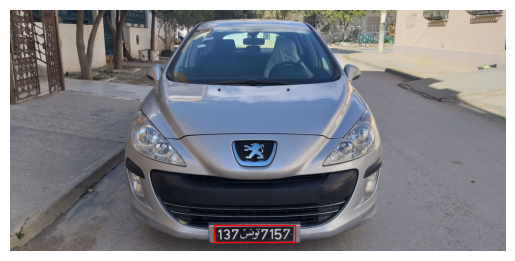

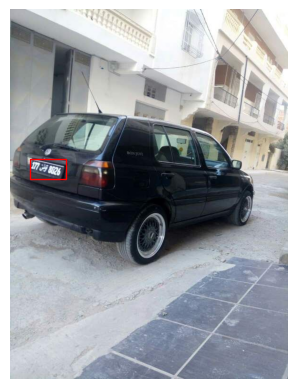

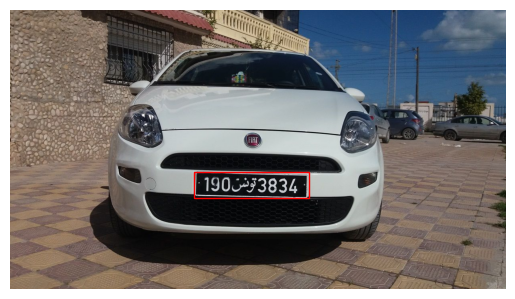

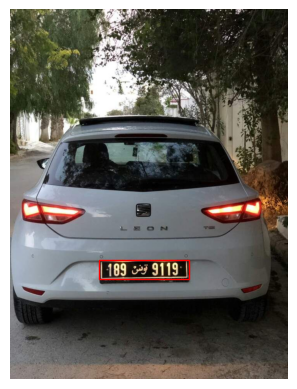

In [37]:
import matplotlib.patches as patches

def plot_image(img_tensor, annotation):
    
    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data

    # Display the image
    ax.imshow(img.permute(1, 2, 0))
    
    for box in annotation["boxes"]:
        xmin, ymin, xmax, ymax = box

        # Create a Rectangle patch
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)
        
    plt.axis('off')
    plt.show()
for idx, (imgs, annotations) in enumerate(train_data_loader):
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    if idx == batch_size:
        break
    else:
        plot_image(imgs[idx], annotations[idx])
        


# Download pretrained model

In [38]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

E:\Softwares\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\Softwares\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [39]:
num_classes = 2 # 1 for backgroumd 1 for number of labels # 1*4out feature because we have four box labels

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


In [40]:
model.roi_heads.box_predictor 

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=2, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=8, bias=True)
)

In [41]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [42]:
# from tqdm.notebook import tqdm
# import math
# for images, targets in tqdm(valid_data_loader):
#     images = list(image.to(device) for image in images)
#     targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
#     print(targets)
#     loss_dict = model(images, targets) 
#     losses = sum(loss for loss in loss_dict.values())
#     loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
#     loss_value = losses.item()
#     print(loss_value)

#     break

First Way of training

In [43]:

# def train_one_epoch(model, optimizer, loader, device, epoch):
#     model.to(device)
#     model.train()
    
#     all_losses = []
#     all_losses_dict = []
    
#     for images, targets in tqdm(loader):
#         # converting tupple to list
#         images = list(image.to(device) for image in images)
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        
#         loss_dict = model(images, targets) 
#         losses = sum(loss for loss in loss_dict.values())
#         loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
#         loss_value = losses.item()
        
#         all_losses.append(loss_value)
#         all_losses_dict.append(loss_dict_append)
        
#         if not math.isfinite(loss_value):
#             print(f"Loss is {loss_value}, stopping trainig") 
#             print(loss_dict)
#             sys.exit(1)
        
#         optimizer.zero_grad()
#         losses.backward()
#         optimizer.step()
        
        
#     all_losses_dict = pd.DataFrame(all_losses_dict)
#     print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
#         epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
#         all_losses_dict['loss_classifier'].mean(),
#         all_losses_dict['loss_box_reg'].mean(),
#         all_losses_dict['loss_rpn_box_reg'].mean(),
#         all_losses_dict['loss_objectness'].mean()
#     ))


# num_epochs=1

# for epoch in range(num_epochs):
#     train_one_epoch(model, optimizer, train_data_loader, device, epoch)

Second Way of training

In [2]:

num_epochs = 25
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

len_dataloader = len(train_data_loader)

for epoch in range(num_epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in tqdm(train_data_loader):
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
#         print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
        epoch_loss += losses
    print(epoch_loss)


# Test Model

In [61]:
device = torch.device('cpu') if torch.cuda.is_available() else torch.device('cpu')
for imgs, annotations in valid_data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations,"\n\n")
    model.eval()
    with torch.no_grad(): # grad should not be calculated in forward pass in eval mode
        preds_annotations = model(imgs)
        preds_annotations = [{k: v.to(device) for k, v in t.items()} for t in preds_annotations]
        print(preds_annotations)
    break

[{'boxes': tensor([[460., 695., 581., 738.]]), 'labels': tensor([1]), 'image_id': tensor([137]), 'area': tensor([5203.]), 'iscrowd': tensor([0])}, {'boxes': tensor([[247., 227., 335., 251.]]), 'labels': tensor([1]), 'image_id': tensor([111]), 'area': tensor([2112.]), 'iscrowd': tensor([0])}, {'boxes': tensor([[306., 401., 482., 455.]]), 'labels': tensor([1]), 'image_id': tensor([75]), 'area': tensor([9504.]), 'iscrowd': tensor([0])}, {'boxes': tensor([[ 948.,  887., 1208.,  945.]]), 'labels': tensor([1]), 'image_id': tensor([73]), 'area': tensor([15080.]), 'iscrowd': tensor([0])}] 


[{'boxes': tensor([[456.6118, 693.7447, 582.8412, 740.3777]]), 'labels': tensor([1]), 'scores': tensor([0.9887])}, {'boxes': tensor([[242.9614, 227.2718, 333.5355, 250.2662]]), 'labels': tensor([1]), 'scores': tensor([0.9803])}, {'boxes': tensor([[300.1933, 399.9425, 493.2916, 453.7334]]), 'labels': tensor([1]), 'scores': tensor([0.9797])}, {'boxes': tensor([[ 947.3812,  882.2628, 1200.9303,  947.5012]]), 

In [62]:
torch.save(model.state_dict(),'model.pt')

In [63]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [64]:
model2 = get_model_instance_segmentation(2)

E:\Softwares\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\Softwares\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [65]:
model2.load_state_dict(torch.load('model.pt'))
model2.eval()
model2.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

Real_image: 


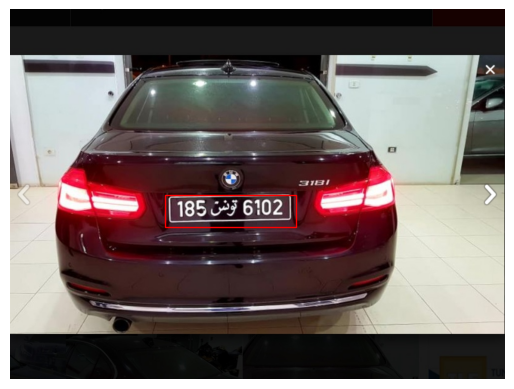

predicted_image: 


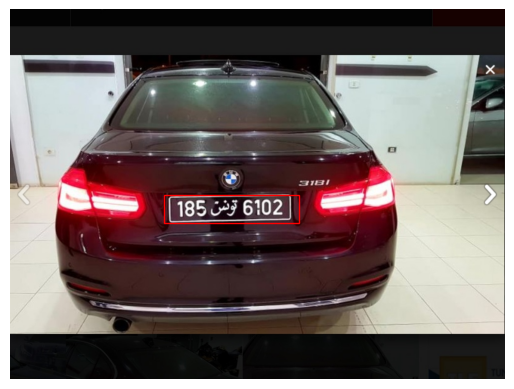

Real_image: 


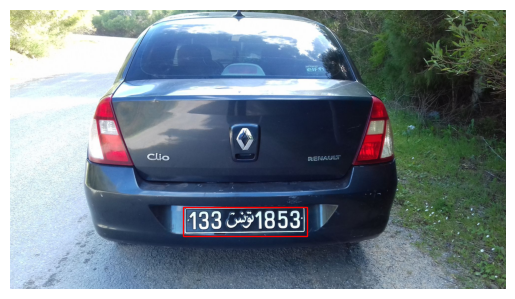

predicted_image: 


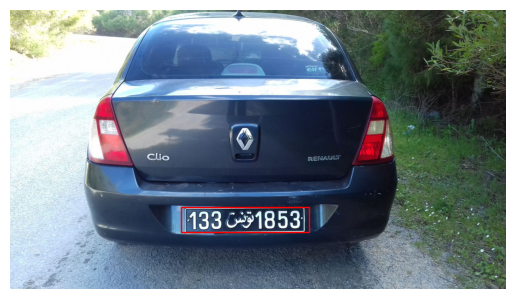

Real_image: 


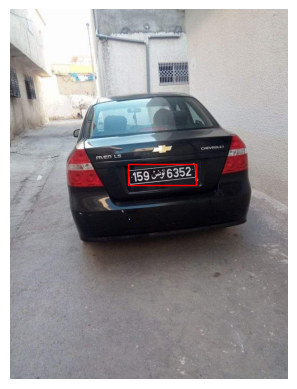

predicted_image: 


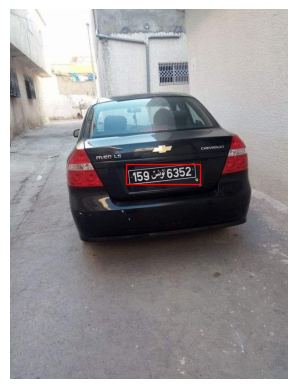

Real_image: 


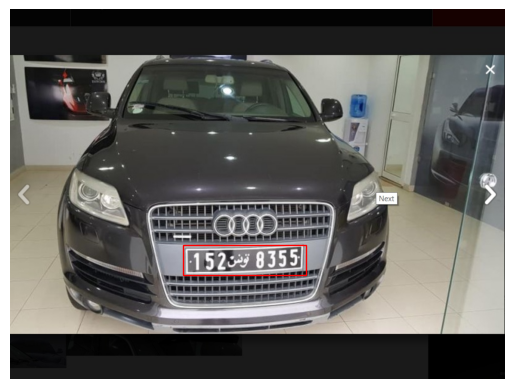

predicted_image: 


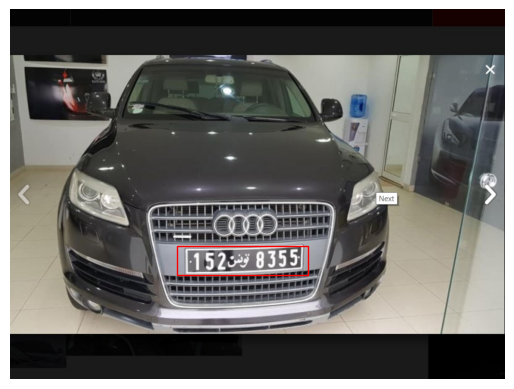

In [68]:
import matplotlib.patches as patches

def plot_image(img_tensor, annotations):
    
    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data

    # Display the image
    ax.imshow(img.permute(1, 2, 0))
    
    for box in annotations["boxes"]:
        xmin, ymin, xmax, ymax = box

        # Create a Rectangle patch
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)
        
    plt.axis('off')
    plt.show()
    
for idx, (imgs, annotations) in enumerate(valid_data_loader):
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    model2.eval()
    with torch.no_grad(): # grad should not be calculated in forward pass in eval mode
        preds_annotations = model2(imgs)
        preds_annotations = [{k: v.to(device) for k, v in t.items()} for t in preds_annotations]

    if idx == batch_size:
        break
    else:
        print("Real_image: ") 
        plot_image(imgs[idx], annotations[idx])
        print("predicted_image: ")
        plot_image(imgs[idx], preds_annotations[idx])
        
